In [35]:
# Importing packages

import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")


In [36]:
# Loading data

df = pd.read_csv('final_data.csv')

In [37]:
df.head()

,Date,bond_yield,budget_sur_def,fed_interest_rates,m2_money_supply,unemployment,us_dollar_index,volatility_index,cpi_all,cpi_adjusted,debt_to_gdp
0,1990-01-01,8.99,8282.0,7.97,1.848,5.4,94.540001,17.24,127.5,4.905908,0.516900
1,1990-02-01,9.22,-35207.0,8.25,1.848,5.3,93.449997,24.87,128.0,4.917559,0.518313
2,1990-03-01,9.37,-53324.0,8.30,1.859,5.2,94.720001,21.90,128.6,5.191525,0.518018
3,1990-04-01,9.46,41829.0,8.30,1.859,5.4,94.320000,22.84,128.9,5.276985,0.513890
4,1990-05-01,9.47,-42482.0,8.11,1.859,5.4,93.300003,18.43,129.1,5.166732,0.526558


In [38]:
# Feature set

X = df.drop(['Date','fed_interest_rates'], axis=1)
X.head()

,bond_yield,budget_sur_def,m2_money_supply,unemployment,us_dollar_index,volatility_index,cpi_all,cpi_adjusted,debt_to_gdp
0,8.99,8282.0,1.848,5.4,94.540001,17.24,127.5,4.905908,0.516900
1,9.22,-35207.0,1.848,5.3,93.449997,24.87,128.0,4.917559,0.518313
2,9.37,-53324.0,1.859,5.2,94.720001,21.90,128.6,5.191525,0.518018
3,9.46,41829.0,1.859,5.4,94.320000,22.84,128.9,5.276985,0.513890
4,9.47,-42482.0,1.859,5.4,93.300003,18.43,129.1,5.166732,0.526558


In [39]:
# Target variable

y = df['fed_interest_rates']

y.head()

0    7.97
1    8.25
2    8.30
3    8.30
4    8.11
Name: fed_interest_rates, dtype: float64

#### Train test split

In [40]:
# Train test split 80-20 split

X_train, X_test, y_train, y_test = train_test_split(X.copy(),y.copy(),
                                                       shuffle=True,
                                                       random_state=153,
                                                       test_size=.2)

#### Standardize the magnitude of numeric features using a scaler

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
X_train_scaled.shape

(328, 9)

#### Cross-Validation setup

In [43]:
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 582)

#### Model 1 - Linear regression

In [44]:
## make an array of zeros that will hold our rmses
mses = np.zeros(5)
rsq = np.zeros(5)

## This keeps track of what split we are on
i = 0

for train_index, test_index in kfold.split(X_train_scaled):

    X_train_train = X_train_scaled[train_index]
    
    y_train_train = y_train.iloc[train_index]
    
    ### Holdout set
    X_train_test = X_train_scaled[test_index]
    
    y_train_test = y_train.iloc[test_index]
    
  
    
    ### This is Model 1 ###

    ## Define the LinearRegression object
    model = LinearRegression(copy_X = True)
    
    ## fit the model

    model.fit(X_train_train,
                  y_train_train.values)
    
    ## get the prediction on holdout set
    pred = model.predict(X_train_test)
    
   
    
    ### Recording the MSES ###

    mses[i] = mean_squared_error(y_train_test.values, pred)
    rsq[i] = r2_score(pred,y_train_test.values)
    
    
    ## increase i by 1
    i = i + 1

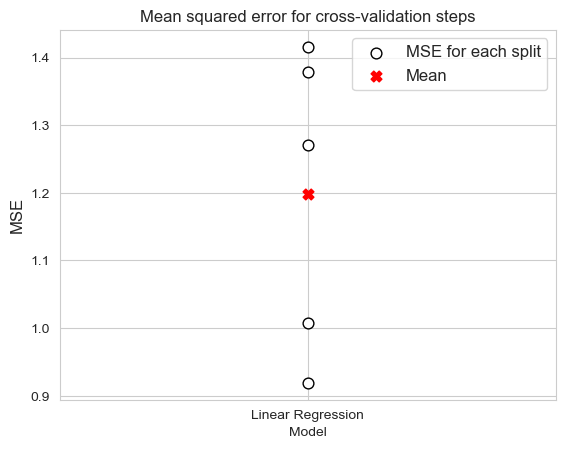

In [45]:

plt.scatter(np.zeros(5), 
            mses, 
            s=60, 
            c='white',
            edgecolor='black',
            label="MSE for each split")

plt.scatter([0], 
            np.mean(mses), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=12)

plt.xticks([0],[ "Linear Regression"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Model", fontsize=10)
plt.ylabel("MSE", fontsize=12)
plt.title('Mean squared error for cross-validation steps')
plt.show()

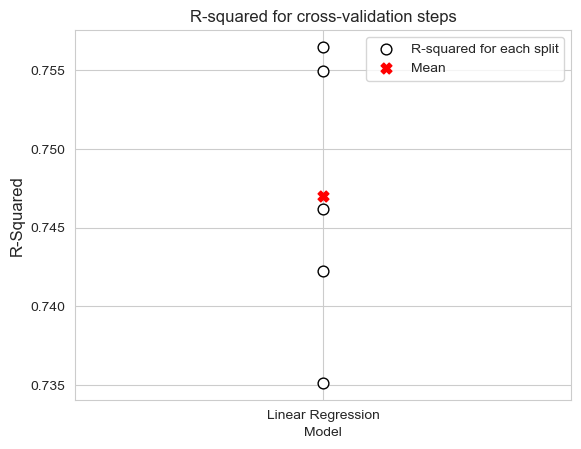

In [49]:
plt.scatter(np.zeros(5), 
            rsq, 
            s=60, 
            c='white',
            edgecolor='black',
            label="R-squared for each split")

plt.scatter([0], 
            np.mean(rsq), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.legend(fontsize=10)

plt.xticks([0],[ "Linear Regression"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Model", fontsize=10)
plt.ylabel("R-Squared", fontsize=12)
plt.title('R-squared for cross-validation steps')
plt.show()

In [47]:
print("The smallest MSE is:", min(mses))

The smallest MSE is: 0.9189360546764591


In [48]:
print("The smallest R-squared is:", min(rsq))

The smallest R-squared is: 0.7351420639415811


#### Model 2: XGBoost

#### Let's do hyperparameter tuning to find best parameters

In [36]:
# Create a Pipeline
xgb_pipeline = Pipeline([("xgb_model",xgb.XGBRegressor())])

In [37]:
# Parameters dictionary

gbm_param_grid = {'xgb_model__subsample': np.arange(.05, 1, .05),'xgb_model__max_depth': np.arange(3,10,1),'xgb_model__colsample_bytree': np.arange(.1,1.05,.05), 'xgb_model__eta': [0.3,0.2,0.1,0.01] }


In [38]:
# GridsearchCV

gridcv_mse = GridSearchCV(estimator=xgb_pipeline,param_grid=gbm_param_grid,scoring='neg_mean_squared_error', cv=5)

In [39]:
gridcv_mse.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constrai...
             param_grid={'xgb_model__colsample_bytree': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'xgb_model__eta': [0.3, 0.2, 0.1, 0.01],
                         'xgb_model__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                         'xgb_model__subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_mean_squared_error')

In [41]:
print("Best mse: ", np.sqrt(np.abs(gridcv_mse.best_score_)))
print("Best model: ", gridcv_mse.best_estimator_)

Best rmse:  0.3940249869642195
Best model:  Pipeline(steps=[('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.45000000000000007, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eta=0.1,
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strate

We see that the best parameters are max_depth=5,colsample_bytree=0.45000000000000007,eta=0.1

##### When we compare model 1 and model 2 we see that model 2 does significantly better than model 1 (using MSE as a evaluation metric). Therefore, let's see how model 2 performs on unseen data (test data)

#### Let's train the model with new parameters

In [50]:
xgb_model = xgb.XGBRegressor(max_depth=5,colsample_bytree=0.45000000000000007,eta=0.1)

In [51]:
xgb_model.fit(X_train_scaled,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.45000000000000007, device=None,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

#### Let's test the model on test data

In [52]:
pred_xgb = xgb_model.predict(X_test_scaled)

In [53]:
print("The mean squared error is:",mean_squared_error(y_test, pred_xgb))

The mean squared error is: 0.08962715624092189


In [54]:
print("The R-squared is:",r2_score(pred_xgb,y_test))

The R-squared is: 0.9836580981225213


In [61]:
y_test2 = list(y_test)

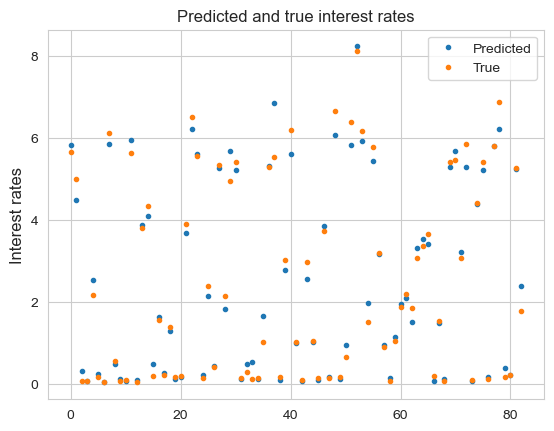

In [68]:
plt.plot(pred_xgb,marker ='.',linestyle='None')
plt.plot(y_test2,marker ='.',linestyle='None')
plt.title('Predicted and true interest rates')
plt.ylabel('Interest rates', fontsize=12)
plt.legend(['Predicted', 'True'])